In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import scipy
import csv

from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import confusion_matrix

In [14]:
# dataset params
val_data_file = "./data/annotated_sheets_pull.csv"
train_data_file = "./data/train.csv"
label_range = ["pee & hand washing", "poo", "object cleaning"]
feature_used = ["elapsed_time", "total_sheets_used", "number_pulled", "max_min_pull_diff", "average_time_between_pulls"]
num_classes = 3

In [3]:
def compute_contigency_matrix(predicted, labels):
    # return: dict[gt_label][cluster_idx]
    assert predicted.shape == labels.shape
    assert len(predicted.shape) == 1
    ret_dict = {}
    assert np.min(predicted) == 0, "cluster idx starts from zero"
    max_cluster_idx = np.max(predicted)
    for name in label_range:
        ret_dict[name] = np.zeros((max_cluster_idx + 1,))
    for i in range(predicted.shape[0]):
        ret_dict[labels[i]][predicted[i]] += 1
    return ret_dict

def normalize_arr(np_arr):
    mean = np.mean(np_arr)
    std = np.std(np_arr)
    return (np_arr - mean) / std

In [4]:
# Reading
train_df = pd.read_csv(train_data_file)
val_df = pd.read_csv(val_data_file)

In [5]:
train_df

,Unnamed: 0,seconds_since_previous_pull,HH_ID,roll_ID,roll_type,starting_time,elapsed_time,total_sheets_used,number_pulled,max_min_pull_diff,multiple_pull_flag,average_time_between_pulls
0,0,10535,B,-1154,Small,2020-02-16 14:09:05,0,4.671975,1,0.000000,False,0.00
1,0,2459,B,-1154,Small,2020-02-16 14:50:04,0,5.909896,1,0.000000,False,0.00
2,0,57729,B,-1154,Small,2020-02-17 06:52:13,93,12.606403,5,5.482473,True,23.25
3,0,2963,B,-1154,Small,2020-02-17 07:43:09,5,6.973858,2,6.350375,True,5.00
4,0,174546,B,-1154,Small,2020-02-19 08:12:20,43,29.098654,5,8.534810,True,10.75
...,...,...,...,...,...,...,...,...,...,...,...,...
5687,0,1919,D,13655,Big,2020-01-13 07:05:46,32,16.694831,3,2.366350,True,16.00
5688,0,347,D,13655,Big,2020-01-13 07:12:05,0,1.861284,1,0.000000,False,0.00
5689,0,29363,D,13655,Big,2020-01-13 15:21:28,6,9.511939,2,2.990052,True,6.00
5690,0,4364,D,13655,Big,2020-01-13 16:34:18,61,29.036462,5,11.062394,True,15.25


### Preprocessing

In [6]:
# Intra-subject group normalization
for subject_name in ["B", "C", "D"]:
    for feature_name in ["total_sheets_used"]:
        sub_feature_vec = train_df.loc[train_df["HH_ID"] == subject_name, "total_sheets_used"].to_numpy()
        train_df.loc[train_df["HH_ID"] == subject_name, "total_sheets_used"] = normalize_arr(sub_feature_vec)

In [7]:
train_df.loc[train_df["HH_ID"] == "B", "total_sheets_used"].to_numpy()

array([-0.41765912, -0.08296251,  1.72757166, ..., -0.0092378 ,
       -1.34195373, -1.36988477])

In [8]:
train_df

,Unnamed: 0,seconds_since_previous_pull,HH_ID,roll_ID,roll_type,starting_time,elapsed_time,total_sheets_used,number_pulled,max_min_pull_diff,multiple_pull_flag,average_time_between_pulls
0,0,10535,B,-1154,Small,2020-02-16 14:09:05,0,-0.417659,1,0.000000,False,0.00
1,0,2459,B,-1154,Small,2020-02-16 14:50:04,0,-0.082963,1,0.000000,False,0.00
2,0,57729,B,-1154,Small,2020-02-17 06:52:13,93,1.727572,5,5.482473,True,23.25
3,0,2963,B,-1154,Small,2020-02-17 07:43:09,5,0.204701,2,6.350375,True,5.00
4,0,174546,B,-1154,Small,2020-02-19 08:12:20,43,6.186580,5,8.534810,True,10.75
...,...,...,...,...,...,...,...,...,...,...,...,...
5687,0,1919,D,13655,Big,2020-01-13 07:05:46,32,0.270242,3,2.366350,True,16.00
5688,0,347,D,13655,Big,2020-01-13 07:12:05,0,-1.183515,1,0.000000,False,0.00
5689,0,29363,D,13655,Big,2020-01-13 15:21:28,6,-0.433715,2,2.990052,True,6.00
5690,0,4364,D,13655,Big,2020-01-13 16:34:18,61,1.479781,5,11.062394,True,15.25


In [9]:
# Get a subset of columns
sub_train_df = train_df[feature_used]
sub_val_df = val_df[feature_used]

In [10]:
kmeans_fit = KMeans(n_clusters = 3, random_state = 1221).fit(sub_train_df)

In [11]:
predicted = kmeans_fit.predict(sub_val_df)

In [12]:
# sklearn routine
contingency_matrix(val_df[["label"]], predicted)

array([[ 23,  23,  21],
       [481,   2,   2],
       [152,  10,   1]])

In [13]:
# more informative contigency matrix routine
my_cmatrix = compute_contigency_matrix(predicted, val_df[["label"]].to_numpy().flatten())
my_cmatrix_np = np.array([my_cmatrix[k] for k in label_range])
pprint(my_cmatrix)
pprint(my_cmatrix_np)
# TODO: dict is unsorted; add assertion here to make sure np is in correct order

{'object cleaning': array([23., 23., 21.]),
 'pee & hand washing': array([481.,   2.,   2.]),
 'poo': array([152.,  10.,   1.])}
array([[481.,   2.,   2.],
       [152.,  10.,   1.],
       [ 23.,  23.,  21.]])


In [ ]:
# Swap to fix clustering label assignment
# TODO: logic broken now
already_assigned_list = []
for i in range(num_classes):
    predicted_cluster_vec = np.array([my_cmatrix[k][i] for k in label_range])
    label_to_assign = -1
    for i in range(num_classes):
        cur_argmax = np.argmax(predicted_cluster_vec)
        if cur_argmax in already_assign_list:
            predicted_cluster_vec[cur_argmax] = -1
            continue
        else:
            label_to_assign = cur_argmax
            break
    assert label_to_assign != -1
    already_assigned_list.append(label_to_assign)


### Accuracy & Confusion Matrix Visualization

In [14]:
# Accuracy
(correct_cnt, total_cnt) = (0, 0)
for i, k in enumerate(my_cmatrix):
    row_total = np.sum(my_cmatrix[k])
    correct_cnt += my_cmatrix[k][i]
    total_cnt += row_total

print("Accuracy: {:.4f}".format(correct_cnt / total_cnt))

Accuracy: 0.7161


In [15]:
# Percentage of No.1 event
print("No.1 event percentage: {}".format(np.sum(my_cmatrix["pee & hand washing"]) / val_df.shape[0]))

No.1 event percentage: 0.6783216783216783


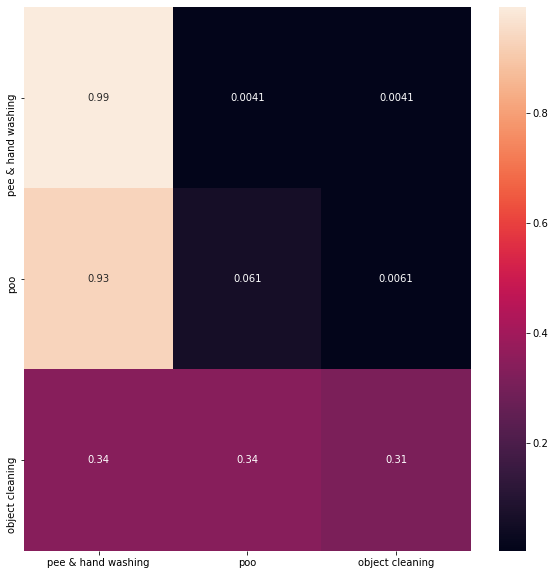

In [16]:
# Confusion matrix
my_cmatrix_np_normalized = my_cmatrix_np.copy()
for i in range(my_cmatrix_np_normalized.shape[0]):
    my_cmatrix_np_normalized[i] = my_cmatrix_np_normalized[i] / np.sum(my_cmatrix_np_normalized[i])
df_cm = pd.DataFrame(my_cmatrix_np_normalized, index = label_range, columns = label_range)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)